# GenAI with Python: Agents from scratch

###### [Article: TowardsDataScience](https://towardsdatascience.com/genai-with-python-build-agents-from-scratch-complete-tutorial-4fc1e084e2ec)

### 0 - Setup

In [1]:
#pip install langchain --> 0.2.14
#pip install langgraph --> 0.2.19
#pip install ollama --> 0.3.1
#pip install duckduckgo-search --> 6.2.12
#pip install wikipedia --> 1.4.0

In [2]:
import ollama

llm = "llama3.1"
q = '''who died on September 9, 2024?'''

res = ollama.chat(model=llm, 
                  messages=[{"role":"system", "content":""},
                            {"role":"user", "content":q}])
res

{'model': 'llama3.1',
 'created_at': '2024-09-26T00:05:35.61313Z',
 'message': {'role': 'assistant',
  'content': "I can't search for information about future events or people who have not yet passed away. Is there anything else I can help you with?"},
 'done_reason': 'stop',
 'done': True,
 'total_duration': 14653605268,
 'load_duration': 7897237659,
 'prompt_eval_count': 22,
 'prompt_eval_duration': 2024591000,
 'eval_count': 29,
 'eval_duration': 4718924000}

### 1 - Tools

In [3]:
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun

@tool("tool_browser")
def tool_browser(q:str) -> str:
    """Search on DuckDuckGo browser by passing the input `q`"""
    return DuckDuckGoSearchRun().run(q)

# test
print( tool_browser(q) )

/var/folders/_z/cl6cx94516g2tlbhzcbl4nfc0000gn/T/ipykernel_10159/3462604742.py:10: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use invoke instead.
  print( tool_browser(q) )


Alberto Fujimori (1938-2024) Sep 11 President of Peru (1990-2000), dies of cancer at 86 [1] Sep 11 Chad McQueen, American actor (Nightforce; The Karate Kid), dies at 63. Sep 14 Otis Davis, American athlete (Olympic gold 400m WR 44.9, 4x400m relay WR 3:02.2 1960), dies at 92. Sep 15 Gheorghe Mulțescu, Romanian soccer midfielder (16 caps; Jiul ... Rochester, Indiana. September 9, 2024 (79 years old) Vickey Karen Bryant. Atkins, Arkansas. September 9, 2024 (72 years old) Kathleen A. Jenkins. Yonkers, New York. September 9, 2024 (73 years old) Tommy Collins Jr. Sept. 9, 2024; Leer en español. James Earl Jones, a stuttering farm child who became a voice of rolling thunder as one of America's most versatile actors in a stage, film and television career ... Actor James Earl Jones, known for his booming voice and many memorable performances, died Monday morning, according to his agent Barry McPherson. ... Mon September 9, 2024 Link Copied! FILE - James Earl Jones arrives before the 84th Academ

In [4]:
@tool("final_answer")
def final_answer(text:str) -> str:
    """Returns a natural language response to the user by passing the input `text`. 
    You should provide as much context as possible and specify the source of the information.
    """
    return text

# test
print( final_answer("yo") )

yo


In [5]:
dic_tools = {"tool_browser":tool_browser, 
             "final_answer":final_answer}

### 2 - Decision Making

In [6]:
prompt = """
You know everything, you must answer every question from the user, you can use the list of tools provided to you.
Your goal is to provide the user with the best possible answer, including key information about the sources and tools used.

Note, when using a tool, you provide the tool name and the arguments to use in JSON format. 
For each call, you MUST ONLY use one tool AND the response format must ALWAYS be in the pattern:
```json
{"name":"<tool_name>", "parameters": {"<tool_input_key>":<tool_input_value>}}
```
Remember, do NOT use any tool with the same query more than once.
Remember, if the user doesn't ask a specific question, you MUST use the `final_answer` tool directly.

Every time the user asks a question, you take note in the memory.
Every time you find some information related to the user's question, you take note in the memory.

You should aim to collect information from a diverse range of sources before providing the answer to the user. 
Once you have collected plenty of information to answer the user's question use the `final_answer` tool.
"""

In [7]:
str_tools = "\n".join([str(n+1)+". `"+str(v.name)+"`: "+str(v.description) for n,v in enumerate(dic_tools.values())])

prompt_tools = f"You can use the following tools:\n{str_tools}"
print(prompt_tools)

You can use the following tools:
1. `tool_browser`: Search on DuckDuckGo browser by passing the input `q`
2. `final_answer`: Returns a natural language response to the user by passing the input `text`. 
    You should provide as much context as possible and specify the source of the information.


In [8]:
# LLM deciding what tool to use
from pprint import pprint

llm_res = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":prompt+"\n"+prompt_tools},
              {"role":"user", "content":"hello"}
             ], format="json")

pprint(llm_res)

{'created_at': '2024-09-26T00:06:15.914695Z',
 'done': True,
 'done_reason': 'stop',
 'eval_count': 24,
 'eval_duration': 3862774000,
 'load_duration': 34963160,
 'message': {'content': '{"name":"final_answer", "parameters": {"text":"Hello! '
                        'I\'m happy to chat with you."}}',
             'role': 'assistant'},
 'model': 'llama3.1',
 'prompt_eval_count': 315,
 'prompt_eval_duration': 30390209000,
 'total_duration': 34291450924}


In [9]:
# LLM deciding what tool to use (output format = json)
llm_res = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":prompt+"\n"+prompt_tools},
              {"role":"user", "content":q}
             ], format="json")

llm_res["message"]["content"]

'{"name":"tool_browser", "parameters":{"q":"September 9 2024 deaths"}}'

In [10]:
import json

tool_input = json.loads(llm_res["message"]["content"])["parameters"]["q"]
tool_input

'September 9 2024 deaths'

In [11]:
# LLM with context
context = tool_browser(tool_input)
print("tool output:\n", context)

llm_output = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":"Give the most accurate answer using the folling information:\n"+context},
              {"role":"user", "content":q}
             ])

print("\nllm output:\n", llm_output["message"]["content"])

tool output:
 Famous deaths in September 2024. Learn about 27 historical figures, notable people and celebrities who died in Sep 2024 like James Earl Jones and Alberto Fujimori. Menu. ... James Earl Jones (1931-2024) Sep 9 American Tony, Emmy, Grammy, and Golden Globe winning actor (The Great White Hope; Star Wars - "voice of Darth Vader"; Field Of Dreams"), ... 1926 William S. Scarborough, American linguist and author (Birds of Aristophanes), dies at 74. 1931 Lujo Brentano, German economist and social reformer, dies at 86. 1934 Roger Fry, English artist and art critic, dies at 67. 1941 Gustav Ehrismann, German author and expert on the German language, dies at 85. Died September 9 2024. News Obituaries James Earl Jones (1931-2024), the voice of Darth Vader and Mufasa. by Linnea Crowther September 9, 2024. Updated on September 22, 2024 08:29PM EDT. After saying sad and shocking goodbyes to the many stars who died in 2023, ... died at Aug. 9 at age 74. A cause of death was not immediatel

### 3 - Agent Structure

##### Data Structure

In [12]:
from pydantic import BaseModel #this is the standard class

# Taking for example the last LLM response, I want this structure:
# {tool_name: 'tool_browser', 
#  tool_input: {'q':'September 9 2024 deaths'}, 
#  tool_output: str( tool_browser({'q':'September 9 2024 deaths'})) }

class AgentRes(BaseModel):
    tool_name: str  #<--must be a string = 'tool_browser'
    tool_input: dict #<--must be a dictionary = {'q':'September 9 2024 deaths'}
    tool_output: str | None = None #can be a string or None, default = None
    
    @classmethod
    def from_llm(cls, res:dict): #<--return the class itself
        try:
            out = json.loads(res["message"]["content"])
            return cls(tool_name=out["name"], tool_input=out["parameters"])
        except Exception as e:
            print(f"Error from Ollama:\n{res}\n")
            raise e

# test
agent_res = AgentRes.from_llm(llm_res)
print("from\n", llm_res["message"]["content"], "\nto")
agent_res

from
 {"name":"tool_browser", "parameters":{"q":"September 9 2024 deaths"}} 
to


AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output=None)

In [13]:
# test the tool output
AgentRes(tool_name="tool_browser", 
         tool_input={'q':'September 9 2024 deaths'}, 
         tool_output=str( tool_browser({'q':'September 9 2024 deaths'})) )

AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output='Famous deaths in September 2024. Learn about 27 historical figures, notable people and celebrities who died in Sep 2024 like James Earl Jones and Alberto Fujimori. Menu. ... James Earl Jones (1931-2024) Sep 9 American Tony, Emmy, Grammy, and Golden Globe winning actor (The Great White Hope; Star Wars - "voice of Darth Vader"; Field Of Dreams"), ... Died September 9 2024. News Obituaries James Earl Jones (1931-2024), the voice of Darth Vader and Mufasa. by Linnea Crowther September 9, 2024. 1926 William S. Scarborough, American linguist and author (Birds of Aristophanes), dies at 74. 1931 Lujo Brentano, German economist and social reformer, dies at 86. 1934 Roger Fry, English artist and art critic, dies at 67. 1941 Gustav Ehrismann, German author and expert on the German language, dies at 85. Deaths in King County, Washington, linked to all drugs have dropped by 15 percent in the first half of 2

##### Memory System

In [14]:
'''
Messages in Memory will have this structure:
[{'role':'assistant', 'content':'{"name":"final_answer", "parameters":{"text":"How can I assist you today?"}}'},
 {'role':'user', 'content':None}]
'''

def save_memory(lst_res:list[AgentRes], user_q:str) -> list:
    ## create
    memory = []
    for res in [res for res in lst_res if res.tool_output is not None]:
        memory.extend([
            ### assistant message
            {"role":"assistant", "content":json.dumps({"name":res.tool_name, "parameters":res.tool_input})},
            ### user message
            {"role":"user", "content":res.tool_output}
        ])
    
    ## add a reminder of the original goal
    if memory:
        memory += [{"role":"user", "content":(f'''
                This is just a reminder that my original query was `{user_q}`.
                Only answer to the original query, and nothing else, but use the information I gave you. 
                Provide as much information as possible when you use the `final_answer` tool.
                ''')}]
    return memory

# test
save_memory(lst_res=[agent_res], user_q=q)

[]

In [15]:
chat_history = [{"role": "user", "content": "hi there, how are you?"},
                {"role": "assistant", "content": "I'm good, thanks!"},
                {"role": "user", "content": "I have a question"},
                {"role": "assistant", "content": "tell me"}]

##### Run the Agent

In [16]:
def run_agent(prompt:str, dic_tools:dict, user_q:str, chat_history:list[dict], lst_res:list[AgentRes]) -> AgentRes:
    ## start memory
    memory = save_memory(lst_res=lst_res, user_q=user_q)
    
    ## track used tools
    if memory:
        tools_used = [res.tool_name for res in lst_res]
        if len(tools_used) >= len(dic_tools.keys()):
            memory[-1]["content"] = "You must now use the `final_answer` tool."

    ## prompt tools
    str_tools = "\n".join([str(n+1)+". `"+str(v.name)+"`: "+str(v.description) for n,v in enumerate(dic_tools.values())])
    prompt_tools = f"You can use the following tools:\n{str_tools}"
        
    ## messages
    messages = [{"role":"system", "content":prompt+"\n"+prompt_tools},
                *chat_history,
                {"role":"user", "content":user_q},
                *memory]
    #pprint(messages) #<--print to see prompt + tools + chat_history
    
    ## output
    llm_res = ollama.chat(model=llm, messages=messages, format="json")
    return AgentRes.from_llm(llm_res)

# test
agent_res = run_agent(prompt=prompt, dic_tools=dic_tools, user_q=q, chat_history=chat_history, lst_res=[])
print("\nagent_res:", agent_res)


agent_res: tool_name='tool_browser' tool_input={'q': 'September 9 2024 deaths'} tool_output=None


### 4 - Graph Workflow

##### State

In [42]:
import typing

class State(typing.TypedDict):
    user_q: str
    chat_history: list 
    lst_res: list[AgentRes]
    output: dict

# test
state = State({"user_q":q, "chat_history":chat_history, "lst_res":[agent_res], "output":{}})
state

{'user_q': 'who died on September 9, 2024?',
 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'},
  {'role': 'assistant', 'content': "I'm good, thanks!"},
  {'role': 'user', 'content': 'I have a question'},
  {'role': 'assistant', 'content': 'tell me'}],
 'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output=None)],
 'output': {}}

##### Nodes

In [43]:
# Agent
def node_agent(state):
    print("--- node_agent ---")
    agent_res = run_agent(prompt=prompt, 
                          dic_tools={k:v for k,v in dic_tools.items() if k in ["tool_browser","final_answer"]},
                          user_q=state["user_q"], 
                          chat_history=state["chat_history"], 
                          lst_res=state["lst_res"])
    print(agent_res)
    return {"lst_res":[agent_res]} #<--must return a the list of agent_res

# test
node_agent(state)

--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'September 9 2024 death'} tool_output=None
--- conditional_edges ---
next_node: tool_browser
tool_name='tool_browser' tool_input={'q': 'September 9 2024 deaths'} tool_output=None


{'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output=None)]}

In [44]:
# Tools
def node_tool(state):
    print("--- node_tool ---")
    res = state["lst_res"][-1]
    print(f"{res.tool_name}(input={res.tool_input})")
    
    agent_res = AgentRes(tool_name=res.tool_name, 
                         tool_input=res.tool_input, 
                         tool_output=str(dic_tools[res.tool_name](res.tool_input)) )
    
    return {"output":agent_res} if res.tool_name == "final_answer" else {"lst_res":[agent_res]}

# test
node_tool(state)

--- node_tool ---
tool_browser(input={'q': 'September 9 2024 deaths'})


{'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output='Famous deaths in September 2024. Learn about 27 historical figures, notable people and celebrities who died in Sep 2024 like James Earl Jones and Alberto Fujimori. Menu. ... James Earl Jones (1931-2024) Sep 9 American Tony, Emmy, Grammy, and Golden Globe winning actor (The Great White Hope; Star Wars - "voice of Darth Vader"; Field Of Dreams"), ... Died September 9 2024. News Obituaries James Earl Jones (1931-2024), the voice of Darth Vader and Mufasa. by Linnea Crowther September 9, 2024. 1926 William S. Scarborough, American linguist and author (Birds of Aristophanes), dies at 74. 1931 Lujo Brentano, German economist and social reformer, dies at 86. 1934 Roger Fry, English artist and art critic, dies at 67. 1941 Gustav Ehrismann, German author and expert on the German language, dies at 85. Updated on September 22, 2024 08:29PM EDT. After saying sad and shocking goodbyes to the ma

##### Edges

In [45]:
def conditional_edges(state):
    print("--- conditional_edges ---")
    last_res = state["lst_res"][-1]
    next_node = last_res.tool_name if isinstance(state["lst_res"], list) else "final_answer"
    print("next_node:", next_node)
    return next_node #<--must return the next node to go

# test
conditional_edges(state)

--- conditional_edges ---
next_node: tool_browser


'tool_browser'

##### Graph

In [46]:
from langgraph.graph import StateGraph, END

## start the graph
workflow = StateGraph(State)

## add Agent node
workflow.add_node(node="Agent", action=node_agent) 
workflow.set_entry_point(key="Agent")  #<--user query

## add Tools nodes
for k in dic_tools.keys():
    workflow.add_node(node=k, action=node_tool)

## conditional_edges from Agent
workflow.add_conditional_edges(source="Agent", path=conditional_edges)

## normal_edges to Agent
for k in dic_tools.keys():
    if k != "final_answer":
        workflow.add_edge(start_key=k, end_key="Agent")

## end the graph
workflow.add_edge(start_key="final_answer", end_key=END)
g = workflow.compile()

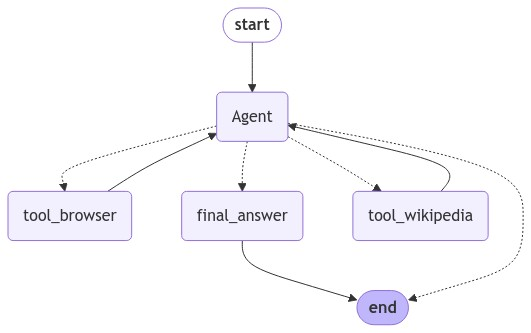

In [47]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(Image(
    g.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
))

##### Run

In [71]:
## input initial state
initial_state = {'user_q':q,
                 'chat_history':chat_history, 
                 'lst_res':[],
                 'output':{} }

In [49]:
out = g.invoke(input=initial_state)
agent_out = out['output'].tool_output

print("----")
agent_out

--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'September 9 2024 death'} tool_output=None
--- conditional_edges ---
next_node: tool_browser
--- node_tool ---
tool_browser(input={'q': 'September 9 2024 death'})
--- node_agent ---
tool_name='final_answer' tool_input={'text': 'According to various news sources [1][2], James Earl Jones (1931-2024), an American actor known for his iconic voice in movies like Star Wars and The Lion King, passed away on September 9, 2024. He was 93 years old.'} tool_output=None
--- conditional_edges ---
next_node: final_answer
--- node_tool ---
final_answer(input={'text': 'According to various news sources [1][2], James Earl Jones (1931-2024), an American actor known for his iconic voice in movies like Star Wars and The Lion King, passed away on September 9, 2024. He was 93 years old.'})
----


'According to various news sources [1][2], James Earl Jones (1931-2024), an American actor known for his iconic voice in movies like Star Wars and The Lion King, passed away on September 9, 2024. He was 93 years old.'

In [50]:
steps = g.stream(input=initial_state) 
for n,step in enumerate(steps):
    print("--- step", n, "---")
    print(step)

--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'September 9 2024 deaths'} tool_output=None
--- conditional_edges ---
next_node: tool_browser
{'Agent': {'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output=None)]}}
----
--- node_tool ---
tool_browser(input={'q': 'September 9 2024 deaths'})
{'tool_browser': {'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output='Famous deaths in September 2024. Learn about 27 historical figures, notable people and celebrities who died in Sep 2024 like James Earl Jones and Alberto Fujimori. Menu. ... James Earl Jones (1931-2024) Sep 9 American Tony, Emmy, Grammy, and Golden Globe winning actor (The Great White Hope; Star Wars - "voice of Darth Vader"; Field Of Dreams"), ... Died September 9 2024. News Obituaries James Earl Jones (1931-2024), the voice of Darth Vader and Mufasa. by Linnea Crowther September 9, 2024. Travis James Mullis, 38, Am

### 5 - Multi-Agent & Human-in-the-Loop

##### Second Agent

In [51]:
agent_out

'According to various news sources [1][2], James Earl Jones (1931-2024), an American actor known for his iconic voice in movies like Star Wars and The Lion King, passed away on September 9, 2024. He was 93 years old.'

In [52]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

@tool("tool_wikipedia")
def tool_wikipedia(q:str) -> str:
    """Search on Wikipedia by passing the input `q`.
       The input `q` must be short keywords, not a long text"""
    return WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper()).run(q)

# test
print( tool_wikipedia(agent_out) )

Page: 2023 in American television
Summary: In American television in 2023, notable events included television show debuts, finales, and cancellations; channel launches, closures, and re-brandings; stations changing or adding their network affiliations; information on controversies, business transactions, and carriage disputes; and deaths of those who made various contributions to the medium.

Page: Bauhaus (band)
Summary: Bauhaus were an English rock band formed in Northampton in 1978. Known for their dark image and gloomy sound, Bauhaus are one of the pioneers of gothic rock, although they mixed many genres, including dub, glam rock, psychedelia, and funk. The group consisted of Daniel Ash (guitar, saxophone), Peter Murphy (vocals, occasional instruments), Kevin Haskins (drums) and David J (bass).
The band formed under the name Bauhaus 1919, in reference to the first operating year of the German art school Bauhaus, but they shortened this name within a year of formation. Their 1979 de

In [53]:
dic_tools = {"tool_browser":tool_browser,
             "final_answer":final_answer,
             "tool_wikipedia":tool_wikipedia}

In [64]:
prompt_2 = """
Your goal is to use the `tool_wikipedia` ONLY ONCE to enrich the information already available.
Note, when using a tool, you provide the tool name and the arguments to use in JSON format. 
For each call, you MUST ONLY use one tool AND the response format must ALWAYS be in the pattern:
```json
{"name":"<tool_name>", "parameters": {"<tool_input_key>":<tool_input_value>}}
```
First you must use the `tool_wikipedia`, then elaborate the information to answer the user's question with `final_answer` tool.
"""

In [65]:
def node_agent_2(state):
    print("--- node_agent 2 ---")
    agent_res = run_agent(prompt=prompt_2, 
                          dic_tools={k:v for k,v in dic_tools.items() if k in ["tool_wikipedia","final_answer"]},
                          user_q=state["output"].tool_output, #<--changed user_q to the last output
                          chat_history=state["chat_history"], 
                          lst_res=state["lst_res"])
    print(agent_res)
    return {"lst_res":[agent_res]} #<--must return a the list of agent_res

##### Human in the Loop

In [66]:
# Node
def human_node(state):
    pass

# Conditional Edges
def human_edges(state):
    print("--- human ---")
    user_feedback = input("Should I continue? [Yes/No] --> ")
    next_node = "Agent2" if user_feedback.lower()[0] == "y" else END
    print("next_node:", next_node)
    return next_node #<--must return the next node to go

# test
human_edges(state)

--- human ---


Should I continue? [Yes/No] -->  y


next_node: Agent2


'Agent2'

##### New Graph

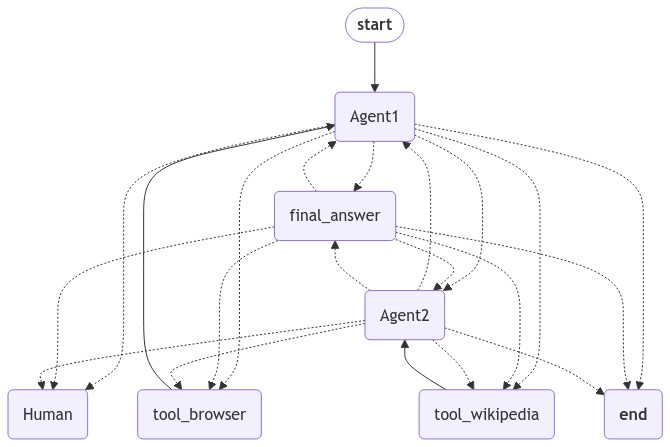

In [67]:
## start the graph
workflow = StateGraph(State)

########################## Agent 1 ##########################
## add Agent node
workflow.add_node(node="Agent1", action=node_agent) 
workflow.set_entry_point(key="Agent1") #<--user query

## add Tools nodes
workflow.add_node(node="tool_browser", action=node_tool)
workflow.add_node(node="final_answer", action=node_tool)

## normal_edges to Agent
workflow.add_edge(start_key="tool_browser", end_key="Agent1")

## conditional_edges from Agent
workflow.add_conditional_edges(source="Agent1", path=conditional_edges)

########################## Human ##########################
## add Human node
workflow.add_node(node="Human", action=human_node)

## conditional_edges from Human
workflow.add_conditional_edges(source="final_answer", path=human_edges)

########################## Agent 2 ##########################
## add Agent node
workflow.add_node(node="Agent2", action=node_agent_2) 

## add Tools nodes
workflow.add_node(node="tool_wikipedia", action=node_tool)

## normal_edges to Agent
workflow.add_edge(start_key="tool_wikipedia", end_key="Agent2")

## conditional_edges from Agent
workflow.add_conditional_edges(source="Agent2", path=conditional_edges)

########################## End ##########################
## end the graph
g2 = workflow.compile()

## plot
display(Image(
    g2.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
))

In [74]:
initial_state

{'user_q': 'who died on September 9, 2024?',
 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'},
  {'role': 'assistant', 'content': "I'm good, thanks!"},
  {'role': 'user', 'content': 'I have a question'},
  {'role': 'assistant', 'content': 'tell me'}],
 'lst_res': [],
 'output': {}}

In [79]:
out_2 = g2.invoke(input=initial_state)
agent_out_2 = out_2['output'].tool_output

print("----")
agent_out_2

--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'September 9 2024 deaths'} tool_output=None
--- conditional_edges ---
next_node: tool_browser
--- node_tool ---
tool_browser(input={'q': 'September 9 2024 deaths'})
--- node_agent ---
tool_name='final_answer' tool_input={'text': 'According to various news sources, including news obituaries, James Earl Jones passed away on September 9, 2024, at his home in Dutchess County, New York. He was an American Tony, Emmy, Grammy, and Golden Globe winning actor, best known for his roles as the voice of Darth Vader and Mufasa.'} tool_output=None
--- conditional_edges ---
next_node: final_answer
--- node_tool ---
final_answer(input={'text': 'According to various news sources, including news obituaries, James Earl Jones passed away on September 9, 2024, at his home in Dutchess County, New York. He was an American Tony, Emmy, Grammy, and Golden Globe winning actor, best known for his roles as the voice of Darth Vader and Mufasa.'})
--- huma

Should I continue? [Yes/No] -->  y


next_node: Agent2
--- node_agent 2 ---
tool_name='tool_wikipedia' tool_input={'q': 'James Earl Jones death date'} tool_output=None
--- conditional_edges ---
next_node: tool_wikipedia
--- node_tool ---
tool_wikipedia(input={'q': 'James Earl Jones death date'})
--- node_agent 2 ---
tool_name='tool_wikipedia' tool_input={'q': 'James Earl Jones death date'} tool_output=None
--- conditional_edges ---
next_node: tool_wikipedia
--- node_tool ---
tool_wikipedia(input={'q': 'James Earl Jones death date'})
--- node_agent 2 ---
tool_name='final_answer' tool_input={'text': "According to various news sources, including news obituaries, James Earl Jones passed away on September 9, 2024, at his home in Dutchess County, New York. He was an American Tony, Emmy, Grammy, and Golden Globe winning actor, best known for his roles as the voice of Darth Vader and Mufasa. According to Wikipedia, James Earl Jones (January 17, 1931 – September 9, 2024) was a renowned American actor with a career spanning over si

Should I continue? [Yes/No] -->  no


next_node: __end__
----


"According to various news sources, including news obituaries, James Earl Jones passed away on September 9, 2024, at his home in Dutchess County, New York. He was an American Tony, Emmy, Grammy, and Golden Globe winning actor, best known for his roles as the voice of Darth Vader and Mufasa. According to Wikipedia, James Earl Jones (January 17, 1931 – September 9, 2024) was a renowned American actor with a career spanning over six decades. He is one of the few performers to achieve EGOT status and won numerous awards for his work on stage and screen. Jones's iconic voice as Darth Vader in the Star Wars franchise and Mufasa in The Lion King are just a couple of his many notable roles. With an extensive career in film, television, and theater, James Earl Jones will be deeply missed by fans around the world."